In [4]:
%matplotlib inline
import torch
import torchvision

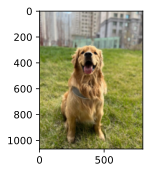

In [5]:
from torch import nn
from d2l import torch as d2l
d2l.set_figsize()
content_img = d2l.Image.open('金毛color.jpeg')
d2l.plt.imshow(content_img);

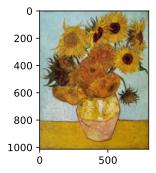

In [6]:
style_img = d2l.Image.open('向日葵.jpeg')
d2l.plt.imshow(style_img);

In [7]:
from PIL import Image
import torchvision

rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, target_shape):
    # Calculate new shape while maintaining aspect ratio
    original_width, original_height = img.size
    target_width, target_height = target_shape
    aspect_ratio = original_width / original_height
    if target_width / target_height > aspect_ratio:
        target_width = int(target_height * aspect_ratio)
    else:
        target_height = int(target_width / aspect_ratio)
    
    # Resize image with new shape
    img = img.resize((target_width, target_height), Image.LANCZOS)
    
    # Apply transformations
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [8]:
pretrained_net = torchvision.models.resnet34(pretrained=True)
#style_layers, content_layers = [0, 5, 10, 19, 28], [25]
content_layers = ['layer3.0.relu']
style_layers = ['relu', 'layer1.0.conv1', 'layer1.2.conv1', 'layer2.0.conv1', 'layer2.2.conv1', 'layer3.0.conv1',
                'layer3.2.conv1']
# print(pretrained_net)

d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#net = nn.Sequential(*[pretrained_net.features[i] for i in
#                    range(max(content_layers + style_layers) + 1)])

In [10]:
def extract_features_resnet(X, content_layers, style_layers):
    features = {}
    hooks = []

    def get_activation(name):
        def hook(model, input, output):
            features[name] = output
        return hook

    # 注册钩子到指定的层
    for name, layer in pretrained_net.named_modules():
        if name in content_layers + style_layers:
            hook = layer.register_forward_hook(get_activation(name))
            hooks.append(hook)

    pretrained_net(X)

    for hook in hooks:
        hook.remove()

    # 提取内容特征和风格特征
    content_features = [features[name] for name in content_layers]
    style_features = [features[name] for name in style_layers]
    return content_features, style_features

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features_resnet(content_X, content_layers, style_layers)
    return content_X, contents_Y


def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features_resnet(style_X, content_layers, style_layers)
    return style_X, styles_Y

# 内容损失
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat- Y.detach()).mean()

# 格拉姆矩阵
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

# 风格损失
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat)- gram_Y.detach()).mean()

# 全变分损失
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :]- Y_hat[:, :, :-1, :]).mean() +
                    torch.abs(Y_hat[:, :, :, 1:]- Y_hat[:, :, :, :-1]).mean())

In [11]:
content_weight, style_weight, tv_weight = 10, 1e4, 1
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [12]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
    def forward(self):
        return self.weight
    
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [13]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features_resnet(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                    float(sum(styles_l)), float(tv_l)])
    return X

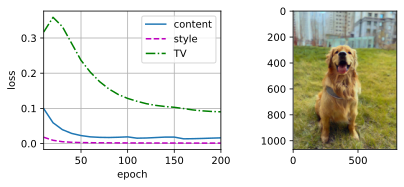

In [14]:
device, image_shape = d2l.try_gpu(), content_img.size
net = pretrained_net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.1, 200, 50)

In [15]:
image = postprocess(output)
image.save('2077_resnet.png')

In [16]:
import cv2
import numpy as np
from PIL import Image

def bilateral_filter(img, d=9, sigma_color=75, sigma_space=75):
    img = np.array(img)
    filtered_img = cv2.bilateralFilter(img, d, sigma_color, sigma_space)
    return Image.fromarray(filtered_img)

# 使用示例
filtered_image = bilateral_filter(postprocess(output))
filtered_image.save('2077_filter.png')

In [17]:
def gaussian_filter(img, kernel_size=5, sigma=1.0):
    img = np.array(img)
    filtered_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)
    return Image.fromarray(filtered_img)

# 使用示例
filtered_image = gaussian_filter(postprocess(output))
filtered_image.save('2077_blur.png')